In [4]:
import datascience as ds
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from datetime import datetime, timedelta
seaborn.set_context(rc={'lines.markeredgewidth': 1.0})
%matplotlib inline
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

The data is named SF_taxi_data.csv, and contains San Francisco Taxi data from 9/1/2012 to 9/17/2012. The dataset consists of 50,000 taxi trips taken in the Bay Area during that time period. For each trip you are given the departure time, arrival time, passenger fare, departure lat/lon coordinates, arrival lat/lon coordinates, departure taz (Traffic Analysis Zone), arrival taz, and the distance between origin and destination in miles.

Data might have outliers and errors. To make sure that you have removed all the outliers, do the following: 

• Get trips where the number of passengers is only 1, and remove fares less than $3.5, since base fare
= $3.5, these are likely to be errors. Do the rest of analysis on this filtered data.

In [5]:
taxi_data=ds.Table.read_table("SF_taxi_data.csv")
taxi_data=taxi_data.where("num", 1)
taxi_data=taxi_data.where(list(map(lambda x: x>=3.5, taxi_data["fare ($)"])))
taxi_data

id,departure time,arrival time,fare ($),num,dep lon,dep lat,arr lon,arr lat,deptaz,arrtaz,dist (miles)
0,9/1/12 0:11,9/1/12 0:20,13.2,1,-122.414,37.8027,-122.421,37.7854,38,30,1.98084
1,9/1/12 0:23,9/1/12 0:31,10.65,1,-122.42,37.7861,-122.435,37.7622,30,94,2.40224
2,9/1/12 0:45,9/1/12 0:49,9,1,-122.415,37.7747,-122.408,37.7826,10,11,0.479348
4,9/1/12 1:09,9/1/12 1:13,7.35,1,-122.43,37.7978,-122.418,37.789,45,32,1.03807
5,9/1/12 1:40,9/1/12 1:52,11.75,1,-122.433,37.7841,-122.411,37.787,77,7,0.960851
6,9/1/12 2:49,9/1/12 2:51,5.15,1,-122.409,37.7856,-122.412,37.791,7,29,0.414315
7,9/1/12 3:29,9/1/12 3:47,43.65,1,-122.403,37.7927,-122.386,37.6181,2,239,14.5105
8,9/1/12 0:33,9/1/12 0:57,46.75,1,-122.387,37.6174,-122.407,37.7889,239,5,14.2747
9,9/1/12 4:39,9/1/12 4:43,6.25,1,-122.422,37.7977,-122.418,37.789,34,31,0.685312
10,9/1/12 1:59,9/1/12 2:05,9.55,1,-122.418,37.791,-122.429,37.7724,32,81,1.59807


In [6]:
taxi_data.group("id").sort("count", descending=True)

id,count
50000,1
49997,1
49996,1
49995,1
49993,1
49992,1
49991,1
49990,1
49989,1
49988,1


Analysis 3. In most trips, the actual fare was way higher than the base one (the equation given in analysis 1). The reason for the extra fare paid by pax is traffic delays (and also drivers taking longer trips than necessary, sometimes due to congestion). Let’s see if this extra surcharge is related to the length and duration of the trip. This will help us predict it before a trip started. Fit a linear regression of travel distance vs. extra cost (the cost above the base fare) on the data from Day 1 to Day 10 of September, and see how the fitted line predicts the fares for data from Day 11 to Day 17? What is the error in prediction?

Analysis 4. Both length and duration of a trip seem to have an association with extra fares. Longer trips are more expensive. Do the same analysis in (3), but for travel duration vs. extra cost, and identify whether trip length or trip duration seem to be a better predictor of the extra travel fare?


In [7]:

 
def get_hour(s): 
    return datetime.strptime(s, "%m/%d/%y %H:%M").hour
 
def get_date(s): 
    return datetime.strptime(s, "%m/%d/%y %H:%M").date()
 
def get_weekday(s): # 0 = Monday - 6= Sunday
    return datetime.strptime(s, "%m/%d/%y %H:%M").date().weekday()
 
def get_dur(start,finish): 
    start_time = datetime.strptime(start, "%m/%d/%y %H:%M")
    end_time = datetime.strptime(finish, "%m/%d/%y %H:%M")
    return (end_time-start_time).total_seconds()/60.

In [8]:
start=taxi_data["departure time"]
end=taxi_data["arrival time"]

duration=np.zeros(taxi_data.num_rows)

for i in range (taxi_data.num_rows):
    duration[i]=get_dur(start[i], end[i])
taxi_data["duration"]=duration

In [9]:
taxi_data["extra_fares"]=taxi_data.column("fare ($)")-(3.5 + 0.5 *5 * taxi_data["dist (miles)"]-0.55)

In [10]:
def standard_units(number):
    return(number-np.mean(number))/np.std(number)

def correlation(x,y):
    return(np.mean(standard_units(x)*standard_units(y)))


def slope(table, x, y):
    r = correlation(table.column(x),table.column(y))
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def fit(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

fit=fit(taxi_data, "duration", "extra_fares")

taxi_data["Linear Prediction"]=fit
errors=taxi_data["duration"]-taxi_data["Linear Prediction"]
taxi_data["errors"]=errors

In [11]:
s=taxi_data["departure time"]
day=np.zeros(taxi_data.num_rows)
for i in range(taxi_data.num_rows):
    day[i]=datetime.strptime(s[i], "%m/%d/%y %H:%M").day
taxi_data["Day"]=day
day1_10=taxi_data.where(taxi_data["Day"]<11)
day11_17=taxi_data.where(taxi_data["Day"]>11)

In [12]:
#DOING IT BY THE MEAN OF EACH DAY

taxi_mean=taxi_data.select("Day", "duration").group("Day", np.mean)
fares_mean=taxi_data.select("Day", "extra_fares").group("Day", np.mean)
taxi_mean["duration"]=taxi_mean["duration mean"]
taxi_mean["extra_fares"]=fares_mean["extra_fares mean"]

regr=linear_model.LinearRegression()
X_trainM=taxi_mean["duration"][0:9]
Y_trainM=taxi_mean["extra_fares"][0:9]
X_trainM=np.reshape(X_trainM, (len(X_trainM),1))
Y_trainM=np.reshape(Y_trainM, (len(Y_trainM),1))

X_testM=taxi_mean["duration"][10:16]
Y_testM=taxi_mean["extra_fares"][10:16]
X_testM=np.reshape(X_testM, (len(X_testM),1))
Y_testM=np.reshape(Y_testM, (len(Y_testM),1))
regr.fit(X_trainM, Y_trainM)

load_predM=regr.predict(X_testM)
print("R-square: %.2f" %r2_score(Y_testM, load_predM))


R-square: 0.93


In [13]:
regr=linear_model.LinearRegression()
X_train=taxi_data["duration"][0:day1_10.num_rows-1]
Y_train=taxi_data["extra_fares"][0:day1_10.num_rows-1]
X_train=np.reshape(X_train, (len(X_train),1))
Y_train=np.reshape(Y_train, (len(Y_train),1))

X_test=taxi_data["duration"][day1_10.num_rows-1:taxi_data.num_rows]
Y_test=taxi_data["extra_fares"][day1_10.num_rows-1:taxi_data.num_rows]
X_test=np.reshape(X_test, (len(X_test),1))
Y_test=np.reshape(Y_test, (len(Y_test),1))
regr.fit(X_train, Y_train)

load_pred=regr.predict(X_test)
print("R-square: %.2f" %r2_score(Y_test, load_pred))

R-square: 0.54


In [14]:
r=correlation(X_train,Y_train)

theta1=r*(np.std(X_train)/np.std(Y_train))
theta2=np.mean(Y_train)-theta1*np.mean(X_train)

In [15]:
rM=correlation(X_trainM,Y_trainM)

theta1M=rM*(np.std(X_trainM)/np.std(Y_trainM))
theta2M=np.mean(Y_trainM)-theta1M*np.mean(X_trainM)


r_test=correlation(X_test, Y_test)
theta1_test=r*(np.std(X_test)/np.std(Y_test))
theta2_test=np.mean(Y_test)-theta1*np.mean(X_test)

In [16]:
taxi_mean=taxi_data.select("Day", "duration").group("Day", np.mean)
fares_mean=taxi_data.select("Day", "extra_fares").group("Day", np.mean)
taxi_mean["duration"]=taxi_mean["duration mean"]
taxi_mean["extra_fares"]=fares_mean["extra_fares mean"]
taxi_mean

Day,duration mean,duration,extra_fares
1,10.2787,10.2787,4.3818
2,10.3479,10.3479,4.37672
3,11.4338,11.4338,5.45725
4,12.002,12.002,5.52396
5,11.5025,11.5025,5.41729
6,11.984,11.984,5.64557
7,11.5367,11.5367,5.15397
8,10.385,10.385,4.55083
9,10.7349,10.7349,5.054
10,11.9967,11.9967,5.8727


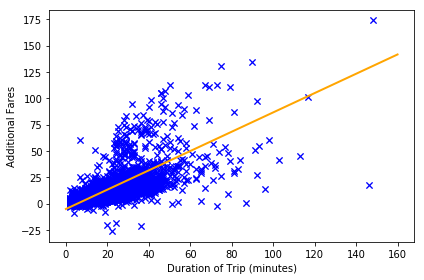

In [17]:
plt.plot(X_train, Y_train, "bx")
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.xlabel("Duration of Trip (minutes)")
plt.ylabel("Additional Fares")
plt.tight_layout()
plt.savefig("scatter.pdf")
xlim=plt.gca().get_xlim()
ylim=plt.gca().get_ylim()

#X = np.vstack([taxi_data["duration"], np.ones(len(taxi_data.column(0)))]).T
#y = taxi_data["extra_fares"]
#theta = np.linalg.solve(X.T.dot(X), X.T.dot(y))

plt.plot(X_train, Y_train, "bx")
xlims=np.array([0, 160])
plt.plot(xlims,theta1*xlims+theta2,lw=2, color="orange")
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.xlabel("Duration of Trip (minutes)")
plt.ylabel("Additional Fares")
plt.tight_layout()
plt.savefig("day1_10.pdf")

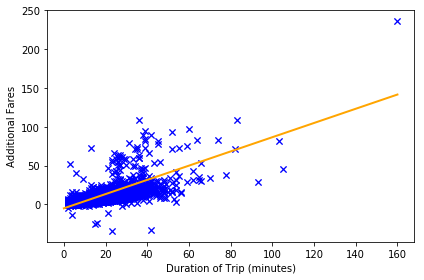

In [18]:
plt.plot(X_test, Y_test, "bx")
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.xlabel("Duration of Trip (minutes)")
plt.ylabel("Additional Fares")
plt.tight_layout()
plt.savefig("scatter.pdf")
xlim=plt.gca().get_xlim()
ylim=plt.gca().get_ylim()

#X = np.vstack([taxi_data["duration"], np.ones(len(taxi_data.column(0)))]).T
#y = taxi_data["extra_fares"]
#theta = np.linalg.solve(X.T.dot(X), X.T.dot(y))

plt.plot(X_test, Y_test, "bx")
xlims=np.array([0, 160])
plt.plot(xlims,theta1*xlims+theta2,lw=2, color="orange")
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.xlabel("Duration of Trip (minutes)")
plt.ylabel("Additional Fares")
plt.tight_layout()
plt.savefig("day1_10.pdf")

In [19]:
#LEAST SQUARE ERROR 
taxi_data

id,departure time,arrival time,fare ($),num,dep lon,dep lat,arr lon,arr lat,deptaz,arrtaz,dist (miles),duration,extra_fares,Linear Prediction,errors,Day
0,9/1/12 0:11,9/1/12 0:20,13.2,1,-122.414,37.8027,-122.421,37.7854,38,30,1.98084,9,5.29791,3.81292,5.18708,1
1,9/1/12 0:23,9/1/12 0:31,10.65,1,-122.42,37.7861,-122.435,37.7622,30,94,2.40224,8,1.6944,3.21438,4.78562,1
2,9/1/12 0:45,9/1/12 0:49,9,1,-122.415,37.7747,-122.408,37.7826,10,11,0.479348,4,4.85163,0.820236,3.17976,1
4,9/1/12 1:09,9/1/12 1:13,7.35,1,-122.43,37.7978,-122.418,37.789,45,32,1.03807,4,1.80482,0.820236,3.17976,1
5,9/1/12 1:40,9/1/12 1:52,11.75,1,-122.433,37.7841,-122.411,37.787,77,7,0.960851,12,6.39787,5.60853,6.39147,1
6,9/1/12 2:49,9/1/12 2:51,5.15,1,-122.409,37.7856,-122.412,37.791,7,29,0.414315,2,1.16421,-0.376836,2.37684,1
7,9/1/12 3:29,9/1/12 3:47,43.65,1,-122.403,37.7927,-122.386,37.6181,2,239,14.5105,18,4.42364,9.19974,8.80026,1
8,9/1/12 0:33,9/1/12 0:57,46.75,1,-122.387,37.6174,-122.407,37.7889,239,5,14.2747,24,8.11327,12.791,11.209,1
9,9/1/12 4:39,9/1/12 4:43,6.25,1,-122.422,37.7977,-122.418,37.789,34,31,0.685312,4,1.58672,0.820236,3.17976,1
10,9/1/12 1:59,9/1/12 2:05,9.55,1,-122.418,37.791,-122.429,37.7724,32,81,1.59807,6,2.60482,2.01731,3.98269,1


In [20]:
fit=theta1*day11_17["duration"]+theta2
(np.absolute(np.mean(day11_17["extra_fares"]-fit**2)))/day11_17.num_rows

0.0085522706101511161